In [ ]:
# NOTE: Place 'processed_cleveland.csv' in same folder before running.

import warnings
warnings.filterwarnings("ignore")

# --- Standard imports ---
import os
from pathlib import Path
import time
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, brier_score_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.utils import resample

In [ ]:
# Optional: SHAP for explainability (install shap if you want)
try:
    import shap
    HAVE_SHAP = True
except Exception:
    HAVE_SHAP = False


In [ ]:
# ----------------------
# Config / file paths
# ----------------------
DATA_FILE = "/content/processed_cleveland.csv"
OUT_DIR = Path("./cvd_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

In [ ]:
# 1. Load and inspect data
# ----------------------
print("Loading dataset:", DATA_FILE)
df = pd.read_csv(DATA_FILE, na_values=["?", "NA", "nan"])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

print("\nDtypes and missing counts:")
print(df.dtypes)
print(df.isnull().sum())

Loading dataset: /content/processed_cleveland.csv
Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Dtypes and missing counts:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [ ]:
# Impute 'ca' and 'thal' with mode
df['ca'].fillna(df['ca'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

# Confirm no missing values remain
print(df[['ca', 'thal']].isnull().sum())


ca      0
thal    0
dtype: int64


In [ ]:
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [ ]:
# 2. Target handling
# ----------------------
# Cleveland commonly uses 'num' (0=no disease, >0=disease). Convert to binary 'target'
if "num" in df.columns:
    df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
    df.drop(columns=["num"], inplace=True)
    print("\nCreated binary 'target' from 'num'. Class balance:")
    print(df["target"].value_counts())
else:
    # fallback - find likely target
    possible = [c for c in df.columns if c.lower() in ("target", "disease", "hd")]
    if possible:
        print("Using '{}' as target".format(possible[0]))
    else:
        raise ValueError("No 'num' column found and no obvious target column.")


Created binary 'target' from 'num'. Class balance:
target
0    164
1    139
Name: count, dtype: int64


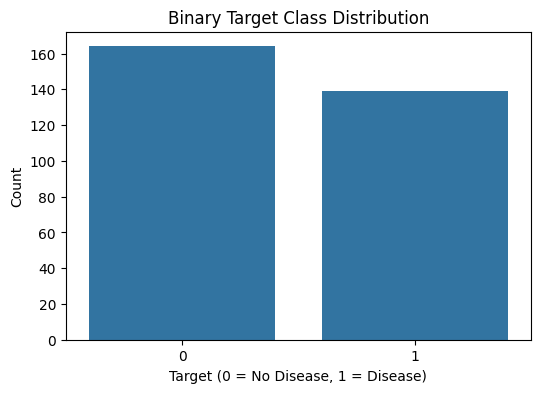

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target')
plt.title('Binary Target Class Distribution')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.show()

In [ ]:
# 4. Exploratory Data Analysis (EDA)
# ----------------------
print("\nRunning EDA and saving plots to:", PLOTS_DIR)

# Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x="target", data=df)
plt.title("Target Distribution (0 = no disease, 1 = disease)")
plt.savefig(PLOTS_DIR / "class_distribution.png")
plt.close()

# Numeric distributions
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "target"]
n = len(num_cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row * 5, rows * 3.5))
for i, c in enumerate(num_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[c], kde=True, bins=20)
    plt.title(c)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "numeric_distributions.png")
plt.close()

# Categorical distributions
cat_cols = [c for c in df.columns if c not in num_cols + ["target"]]
if cat_cols:
    plt.figure(figsize=(5*len(cat_cols),4))
    for i,c in enumerate(cat_cols):
        plt.subplot(1, max(1,len(cat_cols)), i+1)
        sns.countplot(x=c, data=df)
        plt.title(c)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "categorical_counts.png")
    plt.close()

# Correlation heatmap (after one-hot encoding categorical)
df_encoded = pd.get_dummies(df.drop(columns=["target"]), drop_first=True)
corr = df_encoded.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (one-hot encoded)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "correlation_heatmap.png")
plt.close()

# Save a simple EDA report JSON
eda_report = {
    "n_samples": len(df),
    "n_features": len(df.columns)-1,
    "class_balance": df["target"].value_counts().to_dict()
}
with open(OUT_DIR / "eda_summary.json", "w") as f:
    json.dump(eda_report, f, indent=2)

print("EDA complete. Plots saved.")



Running EDA and saving plots to: cvd_outputs/plots
EDA complete. Plots saved.


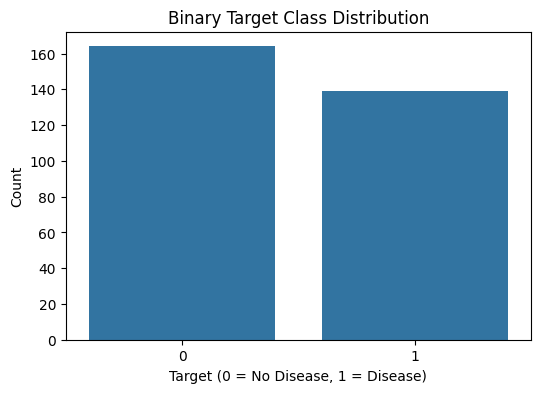


Running EDA and saving plots to: cvd_outputs/plots
EDA complete. Plots saved.

Numeric cols: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']
Categorical cols: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
Train/Test sizes: (242, 13) (61, 13)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target')
plt.title('Binary Target Class Distribution')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.show()

# 4. Exploratory Data Analysis (EDA)
# ----------------------
print("\nRunning EDA and saving plots to:", PLOTS_DIR)

# Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x="target", data=df)
plt.title("Target Distribution (0 = no disease, 1 = disease)")
plt.savefig(PLOTS_DIR / "class_distribution.png")
plt.close()

# Numeric distributions
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "target"]
n = len(num_cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row * 5, rows * 3.5))
for i, c in enumerate(num_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[c], kde=True, bins=20)
    plt.title(c)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "numeric_distributions.png")
plt.close()

# Categorical distributions
cat_cols = [c for c in df.columns if c not in num_cols + ["target"]]
if cat_cols:
    plt.figure(figsize=(5*len(cat_cols),4))
    for i,c in enumerate(cat_cols):
        plt.subplot(1, max(1,len(cat_cols)), i+1)
        sns.countplot(x=c, data=df)
        plt.title(c)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "categorical_counts.png")
    plt.close()

# Correlation heatmap (after one-hot encoding categorical)
df_encoded = pd.get_dummies(df.drop(columns=["target"]), drop_first=True)
corr = df_encoded.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (one-hot encoded)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "correlation_heatmap.png")
plt.close()

# Save a simple EDA report JSON
eda_report = {
    "n_samples": len(df),
    "n_features": len(df.columns)-1,
    "class_balance": df["target"].value_counts().to_dict()
}
with open(OUT_DIR / "eda_summary.json", "w") as f:
    json.dump(eda_report, f, indent=2)

print("EDA complete. Plots saved.")

# 5. Train/test split & preprocessing pipeline
# ----------------------
X = df.drop(columns=["target"]).copy()
y = df["target"].copy()

# Decide numeric vs categorical for pipeline
numeric_cols = [c for c in X.columns if (pd.api.types.is_float_dtype(X[c]) or (pd.api.types.is_integer_dtype(X[c]) and X[c].nunique() > 6))]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("\nNumeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)

# Preprocessors
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
], remainder="drop")

In [ ]:
# 6. Models & baseline CV comparison
# ----------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, solver="liblinear", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42)
}

pipelines = {name: Pipeline([("pre", preprocessor), ("clf", clf)]) for name, clf in models.items()}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
print("\nCross-validated comparison (ROC AUC and Accuracy):")
for name, pipe in pipelines.items():
    t0 = time.time()
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=1)
    acc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=1)
    cv_results[name] = {"roc_auc_mean": float(np.mean(auc_scores)), "roc_auc_std": float(np.std(auc_scores)), "acc_mean": float(np.mean(acc_scores))}
    print(f"{name}: AUC={np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}, Acc={np.mean(acc_scores):.4f} (time {time.time()-t0:.1f}s)")

with open(OUT_DIR / "cv_results.json", "w") as f:
    json.dump(cv_results, f, indent=2)



Cross-validated comparison (ROC AUC and Accuracy):
LogisticRegression: AUC=0.9048 ± 0.0197, Acc=0.8429 (time 0.3s)
RandomForest: AUC=0.8913 ± 0.0281, Acc=0.8222 (time 4.4s)
SVM: AUC=0.8873 ± 0.0204, Acc=0.8264 (time 0.3s)
KNN: AUC=0.8718 ± 0.0352, Acc=0.8057 (time 0.3s)
DecisionTree: AUC=0.7077 ± 0.0399, Acc=0.7106 (time 0.3s)


In [ ]:
# 7. Nested CV estimate for model stability (lightweight)
# ----------------------
def nested_cv_light(pipeline, param_dist, X, y, outer_splits=4, inner_iter=6):
    outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    outer_scores = []
    for train_idx, test_idx in outer.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        rs = RandomizedSearchCV(pipeline, param_dist, n_iter=inner_iter, cv=3, scoring="roc_auc", random_state=42, n_jobs=1)
        rs.fit(X_tr, y_tr)
        best = rs.best_estimator_
        y_proba = best.predict_proba(X_val)[:,1]
        outer_scores.append(roc_auc_score(y_val, y_proba))
    return np.array(outer_scores)

# Param spaces (small for speed)
param_lr = {"clf__C": [0.01, 0.1, 1, 10, 100], "clf__penalty": ["l2"]}
param_rf = {"clf__n_estimators": [50, 100, 200], "clf__max_depth": [None, 5, 10], "clf__min_samples_split": [2, 5]}

print("\nRunning lightweight nested CV for LogisticRegression and RandomForest...")
lr_nested = nested_cv_light(pipelines["LogisticRegression"], param_lr, X_train, y_train, outer_splits=4, inner_iter=6)
rf_nested = nested_cv_light(pipelines["RandomForest"], param_rf, X_train, y_train, outer_splits=4, inner_iter=6)
print("LR nested AUC mean±std:", lr_nested.mean(), lr_nested.std())
print("RF nested AUC mean±std:", rf_nested.mean(), rf_nested.std())



Running lightweight nested CV for LogisticRegression and RandomForest...
LR nested AUC mean±std: 0.9003417733886484 0.024134545057330637
RF nested AUC mean±std: 0.8923204014349848 0.018837823112858643


In [ ]:
# 8. Hyperparameter tuning (RandomizedSearchCV) on the training set
# ----------------------
rs_lr = RandomizedSearchCV(pipelines["LogisticRegression"], param_distributions=param_lr, n_iter=8, cv=cv, scoring="roc_auc", random_state=42, n_jobs=1)
rs_rf = RandomizedSearchCV(pipelines["RandomForest"], param_distributions=param_rf, n_iter=8, cv=cv, scoring="roc_auc", random_state=42, n_jobs=1)

print("\nTuning LogisticRegression...")
rs_lr.fit(X_train, y_train)
print("Best LR params:", rs_lr.best_params_, "Best LR CV AUC:", rs_lr.best_score_)

print("\nTuning RandomForest...")
rs_rf.fit(X_train, y_train)
print("Best RF params:", rs_rf.best_params_, "Best RF CV AUC:", rs_rf.best_score_)

best_lr = rs_lr.best_estimator_
best_rf = rs_rf.best_estimator_


Tuning LogisticRegression...
Best LR params: {'clf__penalty': 'l2', 'clf__C': 0.1} Best LR CV AUC: 0.9108903978469195

Tuning RandomForest...
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__max_depth': 5} Best RF CV AUC: 0.8969449230318796


In [ ]:
# 9. Evaluate tuned models on the hold-out test set
# ----------------------
def evaluate(est, X_test, y_test, name):
    y_pred = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_proba = est.predict_proba(X_test)[:,1]
    else:
        y_proba = est.decision_function(X_test)
    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_proba)),
        "average_precision": float(average_precision_score(y_test, y_proba)),
        "brier": float(brier_score_loss(y_test, y_proba))
    }
    print(f"\n{name} test metrics:")
    for k,v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return metrics, y_proba, y_pred

lr_metrics, lr_proba, lr_pred = evaluate(best_lr, X_test, y_test, "LogisticRegression (tuned)")
rf_metrics, rf_proba, rf_pred = evaluate(best_rf, X_test, y_test, "RandomForest (tuned)")

final_evals = {"LogisticRegression": lr_metrics, "RandomForest": rf_metrics}
with open(OUT_DIR / "final_evaluations.json", "w") as f:
    json.dump(final_evals, f, indent=2)


LogisticRegression (tuned) test metrics:
  accuracy: 0.8689
  f1: 0.8667
  precision: 0.8125
  recall: 0.9286
  roc_auc: 0.9578
  average_precision: 0.9441
  brier: 0.0902

Confusion Matrix:
 [[27  6]
 [ 2 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


RandomForest (tuned) test metrics:
  accuracy: 0.9180
  f1: 0.9153
  precision: 0.8710
  recall: 0.9643
  roc_auc: 0.9643
  average_precision: 0.9549
  brier: 0.0930

Confusion Matrix:
 [[29  4]
 [ 1 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.87      0.96      0.92        28

    accuracy                           0.

In [ ]:
# 10. ROC, PR, calibration plots for best model
# ----------------------
best_name = "LogisticRegression" if lr_metrics["roc_auc"] >= rf_metrics["roc_auc"] else "RandomForest"
best_proba = lr_proba if best_name == "LogisticRegression" else rf_proba
best_model = best_lr if best_name == "LogisticRegression" else best_rf
print("\nSelected best model:", best_name)

# ROC
fpr, tpr, _ = roc_curve(y_test, best_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_test,best_proba):.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "roc_curve.png")
plt.close()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, best_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"{best_name} (AP={average_precision_score(y_test,best_proba):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "pr_curve.png")
plt.close()

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, best_proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "calibration_curve.png")
plt.close()



Selected best model: RandomForest


In [ ]:
# 11. Calibration improvement (isotonic or sigmoid) using validation split
# ----------------------
# Fit calibrator on portion of train set, then evaluate calibrated probabilities
X_tr_part, X_val_part, y_tr_part, y_val_part = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
# Fit best_model on X_tr_part
best_model.fit(X_tr_part, y_tr_part)
# Build preprocessed training representation for calibrator
pre = best_model.named_steps["pre"]
clf = best_model.named_steps["clf"]
X_val_pre = pre.transform(X_val_part)
try:
    # Use isotonic if enough samples, otherwise sigmoid (Platt)
    method = "isotonic" if len(y_val_part) >= 100 else "sigmoid"
    calibrator = CalibratedClassifierCV(clf, method=method, cv="prefit")
    calibrator.fit(pre.transform(X_val_part), y_val_part)
    # Adapter to apply preprocessor then calibrated classifier for predictions
    class CalibratedAdapter:
        def __init__(self, preprocessor, calibrated_clf):
            self.pre = preprocessor
            self.clf = calibrated_clf
        def predict_proba(self, X):
            return self.clf.predict_proba(self.pre.transform(X))
        def predict(self, X):
            return np.argmax(self.predict_proba(X), axis=1)
    calibrated_pipeline = CalibratedAdapter(pre, calibrator)
    cal_proba = calibrated_pipeline.predict_proba(X_test)[:,1]
    # Save calibration plot after calibration
    pt, pp = calibration_curve(y_test, cal_proba, n_bins=10)
    plt.figure(figsize=(6,4)); plt.plot(pp, pt, marker="o"); plt.plot([0,1],[0,1],"--", color="gray"); plt.title("Calibration after calibration"); plt.tight_layout(); plt.savefig(PLOTS_DIR / "calibration_after.png"); plt.close()
    print("Calibration saved (method: {})".format(method))
except Exception as e:
    print("Calibration failed:", e)

Calibration saved (method: sigmoid)


In [ ]:
# 12. Bootstrap confidence interval for AUC (best model)
# ----------------------
def bootstrap_auc(model_pipeline, X_test_df, y_test_ser, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y_test_ser)
    aucs = []
    X_test_df = X_test_df.reset_index(drop=True)
    y_test_ser = y_test_ser.reset_index(drop=True)
    for i in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        Xb = X_test_df.iloc[idx]
        yb = y_test_ser.iloc[idx]
        if hasattr(model_pipeline, "predict_proba"):
            proba = model_pipeline.predict_proba(Xb)[:,1]
        else:
            proba = model_pipeline.decision_function(Xb)
        try:
            aucs.append(roc_auc_score(yb, proba))
        except ValueError:
            pass
    aucs = np.array(aucs)
    return float(np.mean(aucs)), (float(np.percentile(aucs, 2.5)), float(np.percentile(aucs, 97.5)))

print("\nComputing bootstrap CI for AUC (this may take a little while)...")
mean_auc, (lo, hi) = bootstrap_auc(best_model, X_test, y_test, n_bootstraps=300, seed=42)
print(f"AUC mean (bootstrap) = {mean_auc:.4f}, 95% CI = [{lo:.4f}, {hi:.4f}]")


Computing bootstrap CI for AUC (this may take a little while)...
AUC mean (bootstrap) = 0.9592, 95% CI = [0.8961, 0.9935]


In [ ]:
# 13. Subgroup analysis (sex and age bins if present)
# ----------------------
subgroup_perf = {}
if "sex" in X_test.columns:
    for s in sorted(X_test["sex"].unique()):
        mask = X_test["sex"] == s
        if mask.sum() < 10:
            continue
        proba = best_model.predict_proba(X_test[mask])[:,1]
        subgroup_perf[f"sex_{s}"] = {"n": int(mask.sum()), "auc": float(roc_auc_score(y_test[mask], proba))}
if "age" in X_test.columns:
    bins = [0,40,50,60,70,120]
    labels = ["<40","40-49","50-59","60-69","70+"]
    ages = pd.cut(X_test["age"], bins=bins, labels=labels)
    for lab in labels:
        mask = ages == lab
        if mask.sum() < 10:
            continue
        proba = best_model.predict_proba(X_test[mask])[:,1]
        subgroup_perf[f"age_{lab}"] = {"n": int(mask.sum()), "auc": float(roc_auc_score(y_test[mask], proba))}
print("\nSubgroup performance (AUC):", subgroup_perf)
with open(OUT_DIR / "subgroup_performance.json", "w") as f:
    json.dump(subgroup_perf, f, indent=2)


Subgroup performance (AUC): {'sex_0': {'n': 20, 'auc': 1.0}, 'sex_1': {'n': 41, 'auc': 0.9261904761904762}, 'age_40-49': {'n': 13, 'auc': 1.0}, 'age_50-59': {'n': 28, 'auc': 0.9693877551020408}, 'age_60-69': {'n': 14, 'auc': 0.7555555555555555}}


In [ ]:
# 14. Explainability (SHAP) - optional but highly recommended
# ----------------------
if HAVE_SHAP:
    print("\nRunning SHAP explanations (this can be slow)...")
    try:
        pre = best_model.named_steps["pre"]
        clf = best_model.named_steps["clf"]
        X_train_pre = pre.transform(X_train)
        # Build feature names
        num_names = numeric_cols
        cat_names = []
        # try to get onehot names
        try:
            cat_ohe = pre.named_transformers_["cat"].named_steps["ohe"]
            cat_names = list(cat_ohe.get_feature_names_out(categorical_cols))
        except Exception:
            cat_names = [f"{c}_ohe_dim{i}" for c in categorical_cols for i in range(1)]
        feature_names = num_names + cat_names
        # compute SHAP
        if hasattr(clf, "feature_importances_"):
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_train_pre)
        else:
            explainer = shap.LinearExplainer(clf, X_train_pre, feature_dependence="independent")
            shap_values = explainer.shap_values(X_train_pre)
        # summary plot (save)
        shap.summary_plot(shap_values, X_train_pre, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / "shap_summary.png")
        plt.close()
        print("Saved SHAP summary to:", PLOTS_DIR / "shap_summary.png")
    except Exception as e:
        print("SHAP failed:", e)
else:
    print("\nSHAP is not installed. Install via 'pip install shap' to run explanations.")


Running SHAP explanations (this can be slow)...
Saved SHAP summary to: cvd_outputs/plots/shap_summary.png
